# 3ML with Fermi GBM TTE  and LAT LLE Data
### Purpose

This demonstrates of you can use LLE data directly in 3ML

For more detail on the Fermi TTE plugin, check out its demo.

#### Let's check it out!

Import **3ML** as always to make sure you have the plugin

In [1]:
%matplotlib inline
%matplotlib notebook
import os
import numpy as np
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'
from threeML import *



get_available_plugins()


WARNING UserWarning: Using default configuration from /usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/threeML-0.3.2-py2.7.egg/threeML/config/threeML_config.yml. You might want to copy it to /Users/jburgess/.threeML/threeML_config.yml to customize it and avoid this warning.



Available plugins:

FermiGBMTTELike for Fermi GBM TTE (all detectors)
FermiLATLLELike for Fermi LAT LLE
OGIPLike for All OGIP-compliant instruments
EventListLike for Generic EventList data
SwiftXRTLike for Swift XRT
VERITASLike for VERITAS


We will look at GRB080916C as a test case


**FermiGBM_TTE_Like** takes as arguments:
* a name
* the TTE file name
* background intervals separated by commas
* an inital source interval to fit
* the correct RSP file
* (optional) a polynomial order for background fitting *(0-4)*

**FermiGBM_TTE_Like** will attempt to find the best background polynomial order via a LRT.
The background is fit with an Poisson likehood via method developed by Giacomo V. 

In [2]:
# os.path.join is a way to generate system-independent
# paths (good for unix, windows, Mac...)

data_dir_gbm = os.path.join('gbm','bn080916009')
data_dir_lle = 'lat'
src_selection = "0.-71."


# We start out with a bad background interval to demonstrate a few features

nai3 = FermiGBMTTELike('NAI3',
                         os.path.join(data_dir_gbm, "glg_tte_n3_bn080916009_v01.fit.gz"),
                         "-10-0,100-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir_gbm, "glg_cspec_n3_bn080916009_v07.rsp"),poly_order=-1)

bgo0 = FermiGBMTTELike('BGO0',
                         os.path.join(data_dir_gbm, "glg_tte_b0_bn080916009_v01.fit.gz"),
                         "-10-0,100-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir_gbm, "glg_cspec_b0_bn080916009_v07.rsp"))


lle = FermiLATLLELike("LLE",
                      os.path.join(data_dir_lle, "gll_lle_bn080916009_v10.fit"),
                      os.path.join(data_dir_lle, "gll_pt_bn080916009_v10.fit"),
                      "-100-0,100-200",
                      src_selection,
                      rsp_file=os.path.join(data_dir_lle, "gll_cspec_bn080916009_v10.rsp"),poly_order=-1)

Auto-determined polynomial order: 1





WARNING UserWarning: No TLMIN keyword found. This DRM does not follow OGIP standards. Assuming TLMIN=1


WARNING VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future



Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-determined polynomial order: 1


Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-determined polynomial order: 1


Auto-probed noise models:
- observation: poisson
- background: gaussian


In [3]:
lle.peek()

LLE File Info:


Active Count Error                                  14.6332
Active Counts                                          1821
Active Deadtime                                      5.3301
Active Exposure                                     65.6699
Active Polynomial Counts                            394.438
Active Selections                             [(0.0, 71.0)]
Number of Channels                                       50
Polynomial Order                                          1
Polynomial Selections       [[-100.0, 0.0], [100.0, 200.0]]
Significance                                [40.8943475981]
Total N. Events                                       11230
Unbinned Fit                                          False
dtype: object

Timing Info:


LIGO/GPS seconds since 1980-01-06 UTC (decimal)                  905559179.613
NuSTAR seconds since 2010.0 UTC (decimal)                        -40693634.387
RXTE seconds since 1994.0 UTC (decimal)                          464141567.235
Suzaku seconds since 2000.0 UTC (decimal)                        274839166.613
Swift seconds since 2001.0 UTC (decimal)                         243216768.714
UTC                                                2008-09-16 00:12:45.613 UTC
XMM/Chandra seconds since 1998.0 TT (decimal)                    337911230.797
dtype: object

Fermi MET OBS Start                 2.43216e+08
Fermi MET OBS Stop                  2.43218e+08
Fermi Trigger Time                  2.43217e+08
Fermi UTC OBS Start    2008-09-15T23:56:05.6130
Fermi UTC OBS Stop     2008-09-16T00:29:25.6129
dtype: object

Let's look at the lightcurve of NAI3 to check out background fit:

In [4]:
nai3.view_lightcurve(-10,100.,.5)

<IPython.core.display.Javascript object>

In [5]:
lle.view_lightcurve(-10,100,dt=.5)

<IPython.core.display.Javascript object>

### Energy selection



In [6]:
nai3.set_active_measurements("10.0-30.0", "40.0-900.0")
nai3.view_count_spectrum()

Range 10.0-30.0 translates to channels 6-21
Range 40.0-900.0 translates to channels 27-124
Now using 114 channels out of 128


<IPython.core.display.Javascript object>

In [7]:
bgo0.set_active_measurements("250-43000")
bgo0.view_count_spectrum()

Range 250-43000 translates to channels 1-126
Now using 126 channels out of 128


<IPython.core.display.Javascript object>

In [8]:
lle.set_active_measurements("50000-100000")
lle.view_count_spectrum()

Range 50000-100000 translates to channels 11-16
Now using 6 channels out of 50


<IPython.core.display.Javascript object>

## Fitting!

We are now ready for the standard **3ML** process:


In [9]:
triggerName = 'bn080916009'
ra = 121.8
dec = -61.3

bgo.use_effective_area_correction(.5,1.5)
lle.use_effective_area_correction(.5,1.5)

data_list = DataList(nai3,bgo0,lle )

band = Band()

GRB = PointSource( triggerName, ra, dec, spectral_shape=band )

model = Model( GRB )

model.display()

NameError: name 'bgo' is not defined

In [13]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



,#,Name,Best fit value,Unit
0,0,bn080916009.spectrum.main.Band.K,0.0102 +/- 0.0010,1 / (cm2 keV s)
1,1,bn080916009.spectrum.main.Band.alpha,-1.109 +/- 0.034,
2,2,bn080916009.spectrum.main.Band.xp,(1.08 +/- 0.27)e+03,keV
3,3,bn080916009.spectrum.main.Band.beta,-2.28 +/- 0.05,
4,4,cons_NAI3,1.30 +/- 0.09,



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,0.59,-0.82,0.63,-0.91
0.59,1.00,-0.84,0.76,-0.28
-0.82,-0.84,1.00,-0.93,0.55
0.63,0.76,-0.93,1.00,-0.33
-0.91,-0.28,0.55,-0.33,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,2270.189463
NAI3,1053.852078
BGO0,1186.584887
LLE,29.752498


<IPython.core.display.Javascript object>


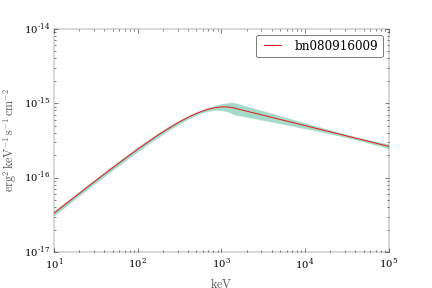

In [14]:
sp = SpectralPlotter(jl)

_=sp.plot_model(y_unit='erg2/(cm2 s keV)', num_ene=200,x_max=1E5)

We can examine our fit with the data:

<IPython.core.display.Javascript object>


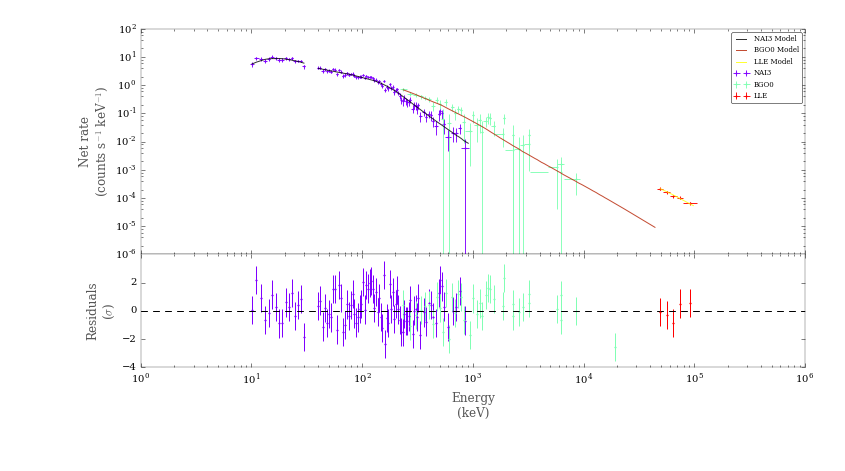

In [17]:
_ = display_ogip_model_counts(jl,min_rate=1,step=False)

In [18]:
res = jl.get_errors()

Name,Value,Unit
bn080916009.spectrum.main.Band.K,0.0102 -0.0009 +0.0010,1 / (cm2 keV s)
bn080916009.spectrum.main.Band.alpha,-1.109 -0.032 +0.04,
bn080916009.spectrum.main.Band.xp,(1.08 -0.24 +0.31)e+03,keV
bn080916009.spectrum.main.Band.beta,-2.28 -0.06 +0.05,
cons_NAI3,1.30 -0.09 +0.09,


<IPython.core.display.Javascript object>


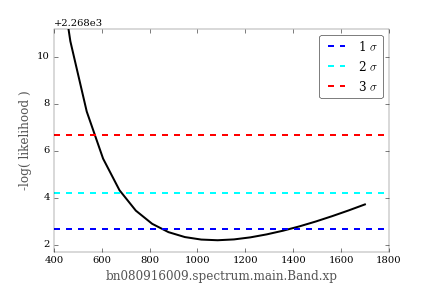

In [19]:
res = jl.get_contours(band.xp,400,1700,20)

<IPython.core.display.Javascript object>


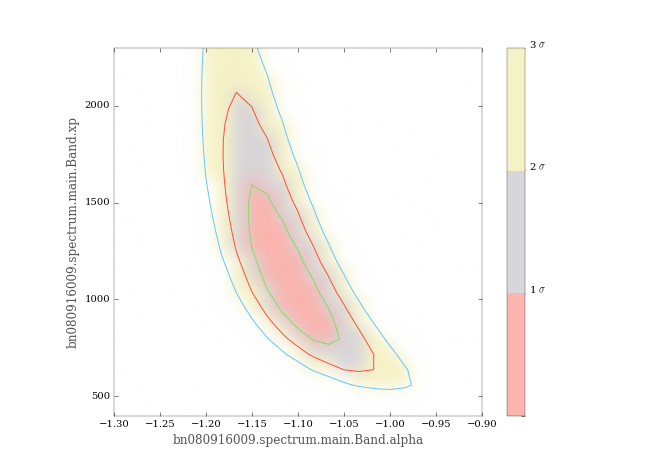

In [20]:
res = jl.get_contours(band.xp,400,2300,25,band.alpha,-1.3,-0.9,25)